In [1]:
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy.modeling import models, fitting
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

## Bar Size Calculation

In [2]:
## Determine length of MOSFIRE bars and slits
pixel_scale = 0.1798 #arcsec per pix
length_of_longslit_pix_Y = np.float64(2044.-8.)
length_of_longslit_pix_X = length_of_longslit_pix_Y * np.tan(3.78*np.pi/180.)
length_of_longslit_pix = np.sqrt(length_of_longslit_pix_X**2 + length_of_longslit_pix_Y**2)
length_of_bar_pix = length_of_longslit_pix/46.
length_of_bar = length_of_bar_pix * pixel_scale

length_of_slit_pix_Y = np.float64(38)  # measured from 4 slits
length_of_slit_pix_X = length_of_slit_pix_Y * np.tan(3.78*np.pi/180.)
length_of_slit_pix = np.sqrt(length_of_slit_pix_X**2 + length_of_slit_pix_Y**2)
length_of_slit = length_of_slit_pix * pixel_scale

overlap = 0.5*(length_of_bar - length_of_slit)

print(f"Bar length {length_of_bar:.3f} arcsec")
print(f"Slit length {length_of_slit:.3f} arcsec")
print(f"Overlap is {overlap:.3f} arcsec on each end")

Bar length 7.975 arcsec
Slit length 6.847 arcsec
Overlap is 0.564 arcsec on each end


## Read CSU Bar State

In [10]:
def read_csu_bar_state(filename):
    with open(filename, 'r') as FO:
        lines = FO.readlines()
    bars = {}
    for line in lines:
        barno, pos, state = line.strip('\n').split(',')
        bars[int(barno)] = float(pos)
    return bars    

In [30]:
filename = 'csu_bar_state.longslit'
bars = read_csu_bar_state(filename)

In [60]:
bars

{1: 144.965,
 2: 145.472,
 3: 144.609,
 4: 145.116,
 5: 144.254,
 6: 144.761,
 7: 143.898,
 8: 144.406,
 9: 143.543,
 10: 144.05,
 11: 143.188,
 12: 143.695,
 13: 142.832,
 14: 143.339,
 15: 142.477,
 16: 142.984,
 17: 142.122,
 18: 142.629,
 19: 141.766,
 20: 142.273,
 21: 141.411,
 22: 141.918,
 23: 141.055,
 24: 141.563,
 25: 140.7,
 26: 141.207,
 27: 140.345,
 28: 140.852,
 29: 139.989,
 30: 140.497,
 31: 139.634,
 32: 140.141,
 33: 139.279,
 34: 139.786,
 35: 138.923,
 36: 139.43,
 37: 138.568,
 38: 139.075,
 39: 138.213,
 40: 138.72,
 41: 137.857,
 42: 138.364,
 43: 137.502,
 44: 138.009,
 45: 137.146,
 46: 137.654,
 47: 136.791,
 48: 137.298,
 49: 136.436,
 50: 136.943,
 51: 136.08,
 52: 136.587,
 53: 135.725,
 54: 136.232,
 55: 135.37,
 56: 135.877,
 57: 135.014,
 58: 135.521,
 59: 134.659,
 60: 135.166,
 61: 134.303,
 62: 134.811,
 63: 133.948,
 64: 134.455,
 65: 133.593,
 66: 134.1,
 67: 133.237,
 68: 133.745,
 69: 132.882,
 70: 133.389,
 71: 132.527,
 72: 133.034,
 73: 132.1

## Detect Bar Positions

In [14]:
mask_image_file = 'm170224_0102.fits'
hdul = fits.open(mask_image_file, 'readonly')
hdul[0].data.shape

(2048, 2048)

In [23]:
def slit_to_bars(j):
    return (j*2+1, j*2+2)

slit_to_bars(1)

(3, 4)

In [15]:
def slit_ypos(j):
    start = 12
    height = (2044.-8.)/46.
    y1 = start + height*j + 0.11/0.1798
    y2 = start + height*(j+1) - 0.11/0.1798
    return(int(np.ceil(y1)), int(np.floor(y2)))
slit_ypos(1)

(57, 99)

In [55]:
def analyze_slit(j, data, plot=False, mm=False):
    y1, y2 = slit_ypos(j)
    i = 4
    filtersize = 5
    slitim = data[y1:y2,:]
    mslit = ndimage.median_filter(slitim, size=(filtersize, filtersize))
    grad = np.gradient(mslit, axis=1)
    profile = np.median(grad, axis=0)
    x1o = list(profile).index(max(profile))
    x2o = list(profile).index(min(profile))
    
    fit_g = fitting.LevMarLSQFitter()
    g_init1 = models.Gaussian1D(amplitude=200., mean=x1o, stddev=2.)
    g_init2 = models.Gaussian1D(amplitude=-200., mean=x2o, stddev=2.)
    g1 = fit_g(g_init1, range(0,2048), profile)
    g2 = fit_g(g_init2, range(0,2048), profile)

    # Check Validity of Fit
    if abs(g1.stddev.value) < 2 and abs(g2.stddev.value) < 2\
       and g1.amplitude.value > 100 and g2.amplitude.value < -100\
       and g1.mean.value < g2.mean.value:
        x1 = g1.mean.value
        x2 = g2.mean.value
    else:
        x1 = 0
        x2 = 0
    
    if plot:
        plt.figure(figsize=(14,3))
        plt.subplot(3,1,1)
        plt.imshow(slitim)
        plt.title(f'Slit {i}')
        plt.xlim(0,2048)
        plt.subplot(3,1,2)
        plt.imshow(mslit)
        plt.xlim(0,2048)
        plt.subplot(3,1,3)
        plt.imshow(grad)
        plt.xlim(0,2048)
        
        plt.figure(figsize=(14,4))
        plt.subplot(2,1,1)
        plt.plot(profile, drawstyle='steps-mid')
        plt.plot([x1, x1], [1.1*min(profile), 1.1*max(profile)], 'r-', alpha=0.4)
        plt.plot([x2, x2], [1.1*min(profile), 1.1*max(profile)], 'r-', alpha=0.4)
        plt.xlim(0,2048)
        plt.subplot(2,1,2)
        plt.plot(profile, drawstyle='steps-mid')
        plt.plot([x1, x1], [1.1*min(profile), 1.1*max(profile)], 'r-', alpha=0.4)
        plt.plot([x2, x2], [1.1*min(profile), 1.1*max(profile)], 'r-', alpha=0.4)
        plt.xlim(x1-20, x2+20)

    if mm:
        line = models.Linear1D(slope=0.124, intercept=8.340)
        return (line(x1), line(x2))
    else:
        return (x1, x2)

In [56]:
def display_CSU_overlay(data):
    plt.figure(figsize=(48,48))
    plt.imshow(data, vmin=0, vmax=2500)
    for j in range(46):
        y1, y2 = slit_ypos(j)
        x1, x2 = analyze_slit(j, hdul[0].data, plot=False)
        if x1==0 or x2==0:
            plt.annotate(f"{j}", (max([x1-50,20]), y2-10), color='r', size=40)
        else:
            plt.annotate(f"{j}", (max([x1-50,20]), y2-10), color='w', size=40)
            plt.fill_between([0,x1], y1, y2, color='g', alpha=0.4)
            plt.fill_between([x2,2048], y1, y2, color='g', alpha=0.4)
    plt.ylim(2048,0)

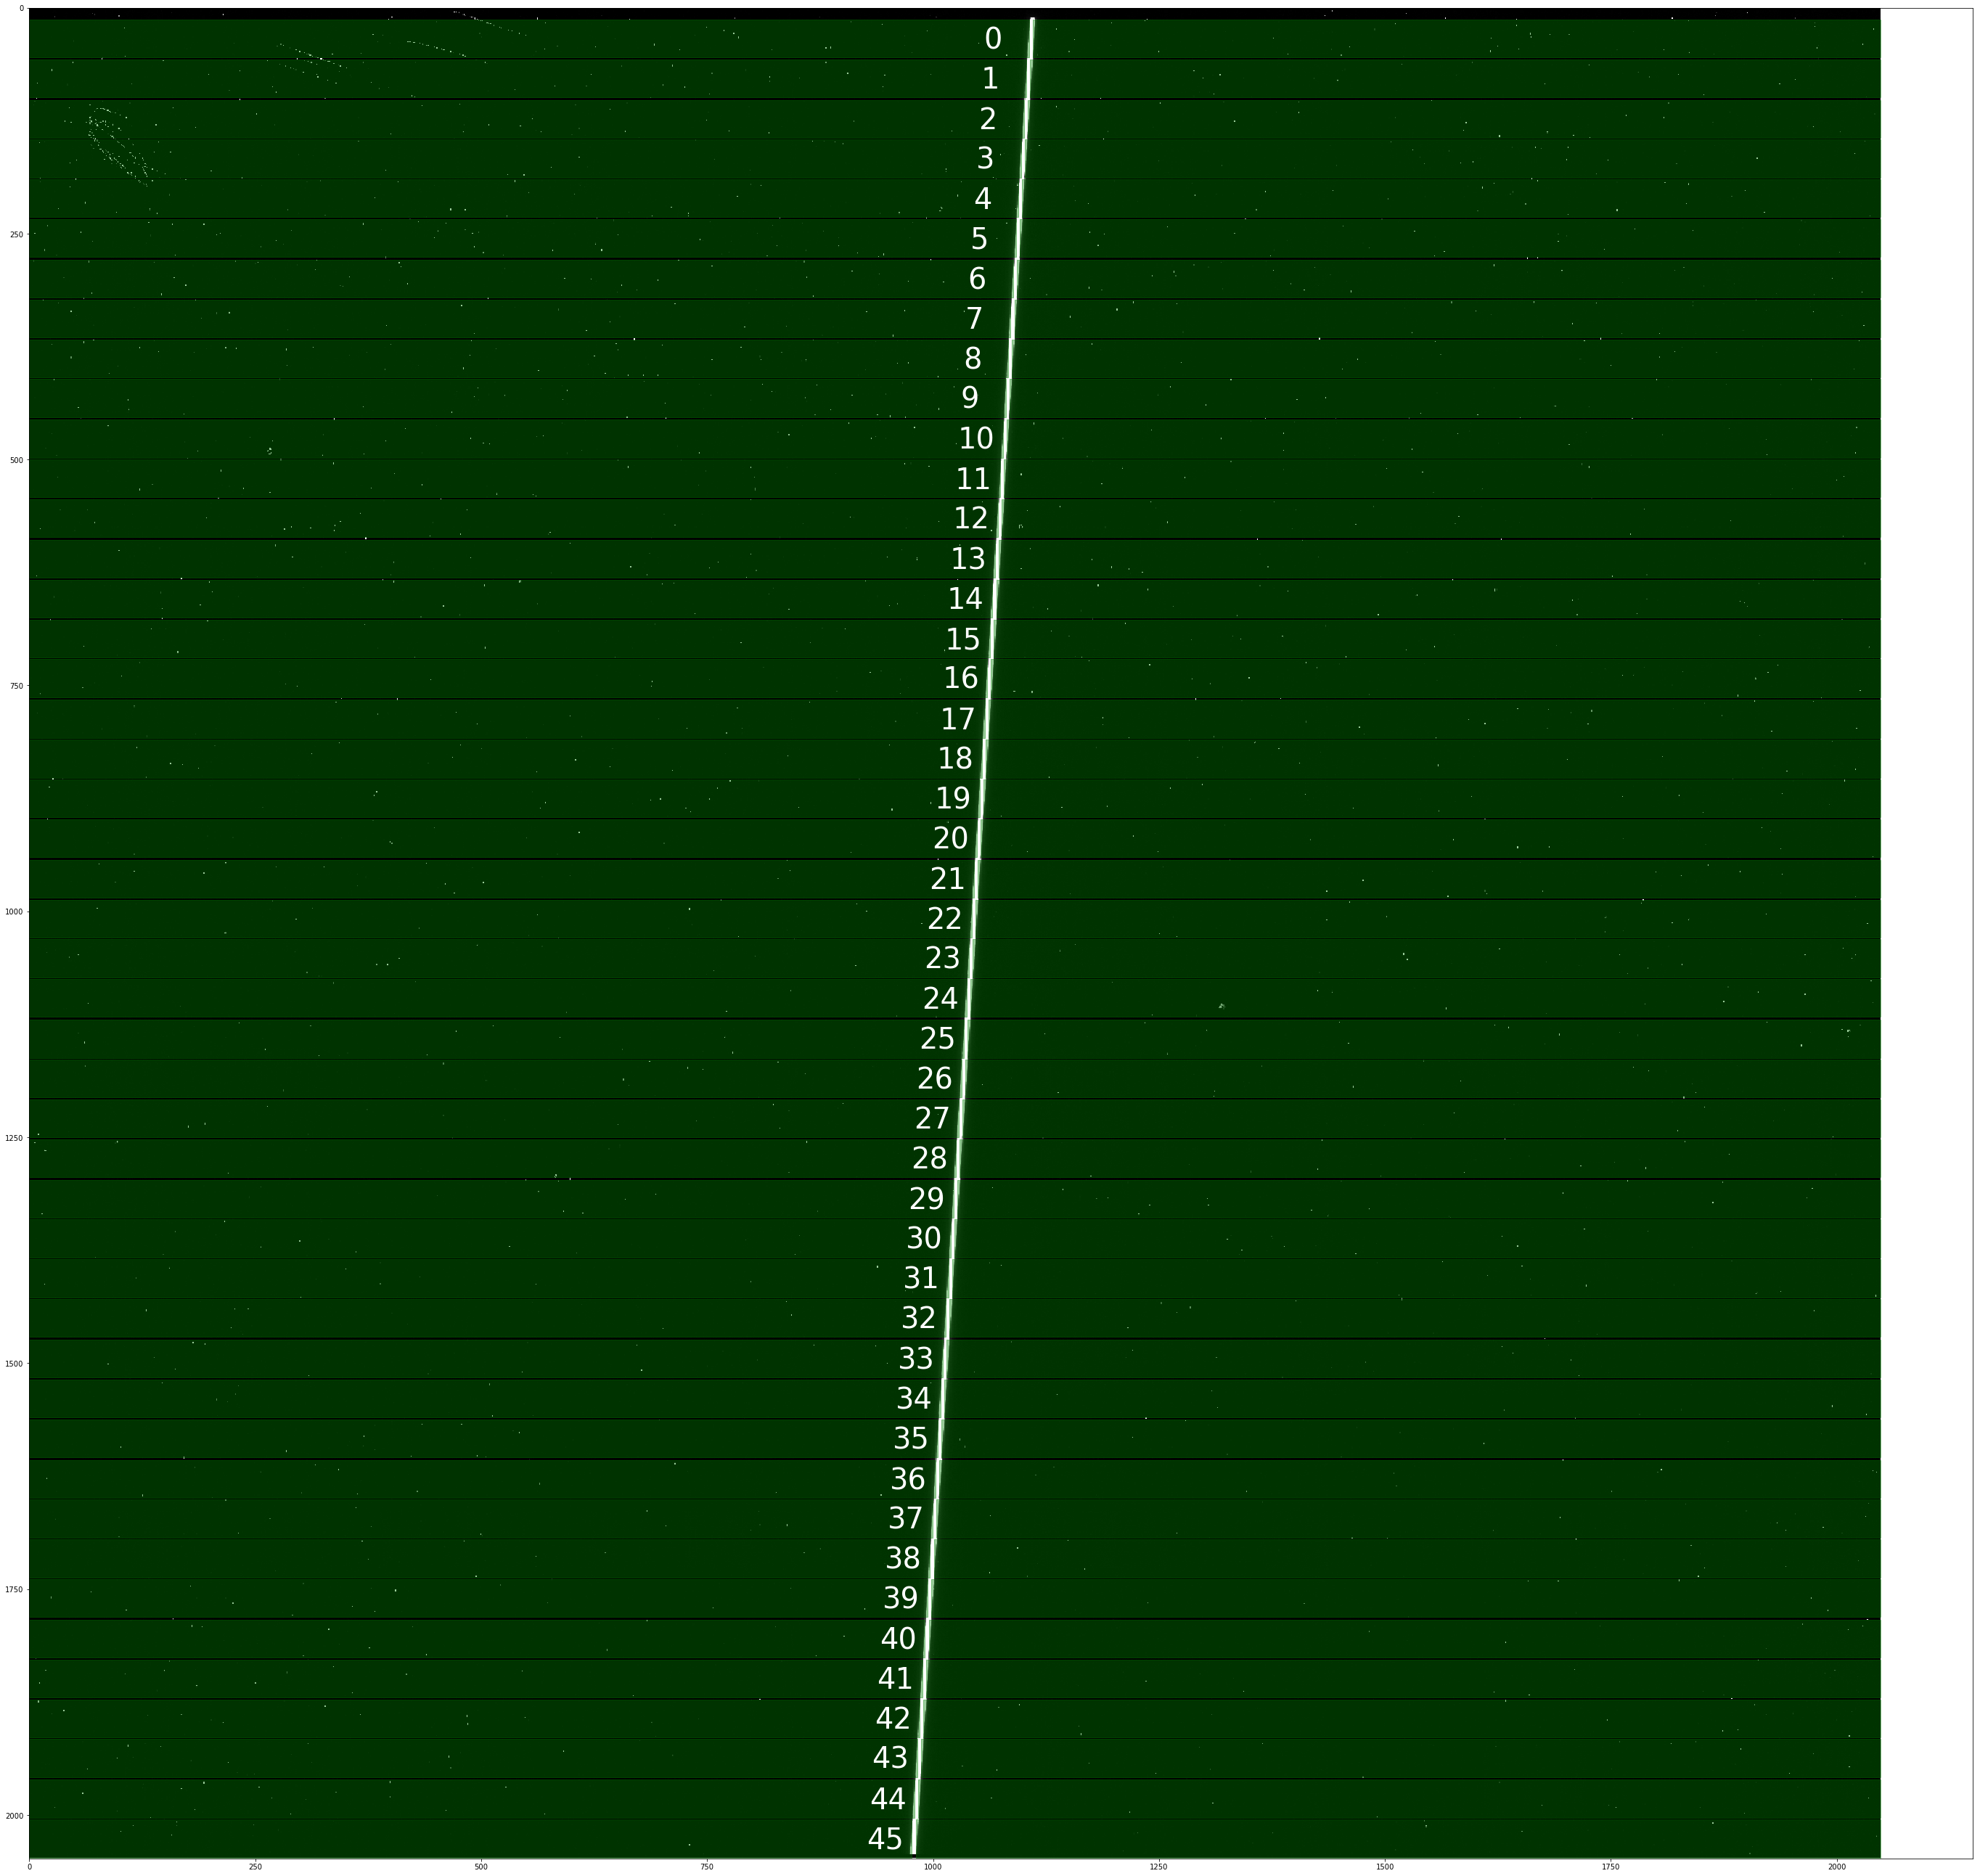

In [57]:
display_CSU_overlay(hdul[0].data)

## Fit pixel to mm Conversion

In [58]:
bars = read_csu_bar_state(filename)

pixels = []
mms = []
for j in range(46):
    xs = analyze_slit(j, hdul[0].data, plot=False)
    bs = slit_to_bars(j)
    pixels.extend(xs)
    mms.append(bars[bs[0]])
    mms.append(bars[bs[1]])

Slope: 0.124 mm/pix
Intercept: 8.340 mm
8.340 mm + 0.124 mm/pix * pixel


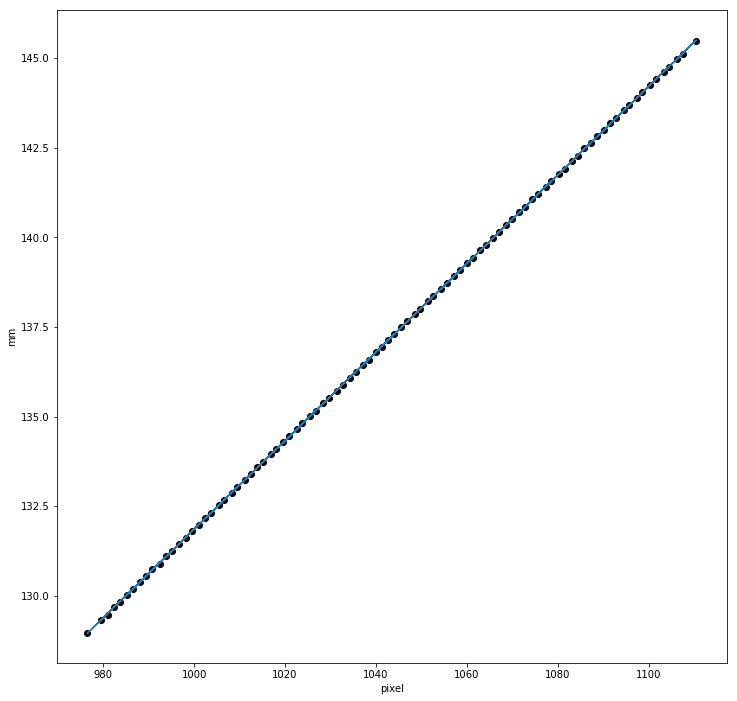

In [59]:
plt.figure(figsize=(12,12))
plt.plot(pixels, mms, 'ko')
plt.xlabel('pixel')
plt.ylabel('mm')

fit_l = fitting.LinearLSQFitter()
lo = models.Linear1D(slope=0.124, intercept=8.340)
line = fit_l(lo, pixels, mms)

plt.plot(pixels, line(pixels))

print(f"Slope: {line.slope.value:.3f} mm/pix")
print(f"Intercept: {line.intercept.value:.3f} mm")
print(f"{line.intercept.value:.3f} mm + {line.slope.value:.3f} mm/pix * pixel")